# Fraud Detection with XGBoost and Triton-FIL

## Introduction
In this example notebook, we will go step-by-step through the process of training and deploying an XGBoost fraud detection model using Triton's new FIL backend. Along the way, we'll show how to analyze the performance of a model deployed in Triton and optimize its performance based on specific SLA targets or other considerations.

## Pre-Requisites
This notebook assumes that you have Docker plus a few Python dependencies. To install all of these dependencies in a conda environment, you may make use of the following conda environment file:
```yaml
---
name: triton_example
channels:
  - conda-forge
  - nvidia
  - rapidsai
dependencies:
  - cudatoolkit=11.4
  - cudf=21.12
  - cuml=21.12
  - cupy
  - jupyter
  - kaggle
  - matplotlib
  - numpy
  - pandas
  - pip
  - python=3.8
  - scikit-learn
  - pip:
      - tritonclient[all]
      - xgboost>=1.5
```

## A Note on Categorical Variables
Categorical variable support was added to the Triton FIL backend in release 21.12 and to XGBoost in release 1.5. If you would like to use an earlier version of either of these or if you simply wish to see how the same workflow would go without explicit categorical variable support, you may set the `USE_CATEGORICAL` variable in the following cell to `false`. Otherwise, by leaving it as `True`, you can take advantage of categorical variable support.

Please note that categorical variable support is still considered experimental in XGBoost 1.5.

In [1]:
USE_CATEGORICAL = False

In [2]:
TRITON_IMAGE = 'nvcr.io/nvidia/tritonserver:21.12-py3'

In [3]:
!docker pull {TRITON_IMAGE}

21.12-py3: Pulling from nvidia/tritonserver

6ab2e44d: Already exists 
a329175c: Already exists 
ce92eb92: Already exists 
fb920a72: Already exists 
7e1512fb: Already exists 
4cbf9454: Already exists 
4b631b03: Already exists 
784680ad: Already exists 
3e677b00: Already exists 
379fbea6: Already exists 
a104e923: Already exists 
501f5fe8: Already exists 
3616ace3: Already exists 
5dd63217: Already exists 
975d8ad8: Already exists 
ba582eac: Already exists 
ff05e0f6: Already exists 
c7255f10: Already exists 
92edeaab: Already exists 
619254c0: Already exists 
1e754dff: Already exists 
5bc48acb: Already exists 
2be54b94: Already exists 
a25c2786: Already exists 
cd37999b: Already exists 
4dea08f3: Already exists 
09f99b2e: Already exists 
fb890a38: Already exists 
500196b9: Already exists 
647f8fed: Already exists 
aec2c293: Already exists 
426cbd87: Already exists 
470ccd52: Already exists 
93f0844c: Already exists 
c8fef418: Already exists 
57973c57: Already exists 
d9b70432: Already e

## Fetching Training Data
For this example, we will make use of data from the [IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection/overview) Kaggle competition. You may fetch the data from this competition using the Kaggle command line client using the following commands.


**NOTE**: You will need to make sure that your Kaggle credentials are [available](https://github.com/Kaggle/kaggle-api#api-credentials) either through a kaggle.json file or via environment variables.

In [4]:
!kaggle competitions download -c ieee-fraud-detection
!unzip -u ieee-fraud-detection.zip
train_csv = 'train_transaction.csv'

 99%|███████████████████████████████████████▌| 117M/118M [00:05<00:00, 21.2MB/s]
100%|████████████████████████████████████████| 118M/118M [00:05<00:00, 21.4MB/s]
Archive:  ieee-fraud-detection.zip
  inflating: sample_submission.csv   
  inflating: test_identity.csv       
  inflating: test_transaction.csv    
  inflating: train_identity.csv      
  inflating: train_transaction.csv   


## Training Example Models
While the IEEE-CIS Kaggle competition focused on a more sophisticated problem involving analysis of both fraudulent transactions and the users linked to those transactions, we will use a simpler version of that problem (identifying fraudulent transactions only) to build our example model. In the following steps, we make use of cuML's preprocessing tools to clean the data and then train two example models using XGBoost. Note that we will be making use of the new categorical feature support in XGBoost 1.5. If you wish to use an earlier version of XGBoost, you will need to perform a [label encoding](https://docs.rapids.ai/api/cuml/stable/api.html?highlight=labelencoder#cuml.preprocessing.LabelEncoder.LabelEncoder) on the categorical features.

In [5]:
import cudf
import cupy as cp
from cuml.preprocessing import SimpleImputer
if not USE_CATEGORICAL:
    from cuml.preprocessing import LabelEncoder
# Due to an upstream bug, cuML's train_test_split function is
# currently non-deterministic. We will therefore use sklearn's
# train_test_split in this example to obtain more consistent
# results.
from sklearn.model_selection import train_test_split

SEED=0

In [6]:
# Load data from CSV files into cuDF DataFrames
data = cudf.read_csv(train_csv)

In [7]:
# Replace NaNs in data
nan_columns = data.columns[data.isna().any().to_pandas()]
float_nan_subset = data[nan_columns].select_dtypes(include='float64')

imputer = SimpleImputer(missing_values=cp.nan, strategy='median')
data[float_nan_subset.columns] = imputer.fit_transform(float_nan_subset)

obj_nan_subset = data[nan_columns].select_dtypes(include='object')
data[obj_nan_subset.columns] = obj_nan_subset.fillna('UNKNOWN')

In [8]:
# Convert string columns to categorical or perform label encoding
cat_columns = data.select_dtypes(include='object')
if USE_CATEGORICAL:
    data[cat_columns.columns] = cat_columns.astype('category')
else:
    for col in cat_columns.columns:
        data[col] = LabelEncoder().fit_transform(data[col])

In [9]:
# Split data into training and testing sets
X = data.drop('isFraud', axis=1)
y = data.isFraud.astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X.to_pandas(), y.to_pandas(), test_size=0.3, stratify=y.to_pandas(), random_state=SEED
)
# Copy data to avoid slowdowns due to fragmentation
X_train = X_train.copy()
X_test = X_test.copy()

In [10]:
import xgboost as xgb

In [11]:
# Define model training function
def train_model(num_trees, max_depth):
    model = xgb.XGBClassifier(
        tree_method='gpu_hist',
        enable_categorical=USE_CATEGORICAL,
        use_label_encoder=False,
        predictor='gpu_predictor',
        eval_metric='aucpr',
        objective='binary:logistic',
        max_depth=max_depth,
        n_estimators=num_trees
    )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)]
    )
    return model

In [12]:
# Train a small model with just 500 trees and a maximum depth of 3
small_model = train_model(500, 3)

[0]	validation_0-aucpr:0.27398
[1]	validation_0-aucpr:0.31137
[2]	validation_0-aucpr:0.36501
[3]	validation_0-aucpr:0.37411
[4]	validation_0-aucpr:0.38408
[5]	validation_0-aucpr:0.41039
[6]	validation_0-aucpr:0.41761
[7]	validation_0-aucpr:0.42502
[8]	validation_0-aucpr:0.43361
[9]	validation_0-aucpr:0.44091
[10]	validation_0-aucpr:0.44511
[11]	validation_0-aucpr:0.44798
[12]	validation_0-aucpr:0.45469
[13]	validation_0-aucpr:0.45892
[14]	validation_0-aucpr:0.46160
[15]	validation_0-aucpr:0.46531
[16]	validation_0-aucpr:0.46899
[17]	validation_0-aucpr:0.47269
[18]	validation_0-aucpr:0.47758
[19]	validation_0-aucpr:0.48164
[20]	validation_0-aucpr:0.48452
[21]	validation_0-aucpr:0.48778
[22]	validation_0-aucpr:0.49041
[23]	validation_0-aucpr:0.49339
[24]	validation_0-aucpr:0.49637
[25]	validation_0-aucpr:0.49816
[26]	validation_0-aucpr:0.50005
[27]	validation_0-aucpr:0.50383
[28]	validation_0-aucpr:0.50801
[29]	validation_0-aucpr:0.51021
[30]	validation_0-aucpr:0.51175
[31]	validation_0-

[252]	validation_0-aucpr:0.63995
[253]	validation_0-aucpr:0.64016
[254]	validation_0-aucpr:0.64027
[255]	validation_0-aucpr:0.64033
[256]	validation_0-aucpr:0.64037
[257]	validation_0-aucpr:0.64070
[258]	validation_0-aucpr:0.64140
[259]	validation_0-aucpr:0.64144
[260]	validation_0-aucpr:0.64169
[261]	validation_0-aucpr:0.64220
[262]	validation_0-aucpr:0.64252
[263]	validation_0-aucpr:0.64321
[264]	validation_0-aucpr:0.64336
[265]	validation_0-aucpr:0.64362
[266]	validation_0-aucpr:0.64372
[267]	validation_0-aucpr:0.64381
[268]	validation_0-aucpr:0.64416
[269]	validation_0-aucpr:0.64450
[270]	validation_0-aucpr:0.64479
[271]	validation_0-aucpr:0.64517
[272]	validation_0-aucpr:0.64564
[273]	validation_0-aucpr:0.64580
[274]	validation_0-aucpr:0.64598
[275]	validation_0-aucpr:0.64615
[276]	validation_0-aucpr:0.64638
[277]	validation_0-aucpr:0.64662
[278]	validation_0-aucpr:0.64662
[279]	validation_0-aucpr:0.64668
[280]	validation_0-aucpr:0.64677
[281]	validation_0-aucpr:0.64691
[282]	vali

In [13]:
# Train a large model with 5000 trees and a maximum depth of 12
large_model = train_model(5000, 12)

[0]	validation_0-aucpr:0.49393
[1]	validation_0-aucpr:0.52723
[2]	validation_0-aucpr:0.56305
[3]	validation_0-aucpr:0.58886
[4]	validation_0-aucpr:0.60925
[5]	validation_0-aucpr:0.62608
[6]	validation_0-aucpr:0.63639
[7]	validation_0-aucpr:0.65154
[8]	validation_0-aucpr:0.66224
[9]	validation_0-aucpr:0.67058
[10]	validation_0-aucpr:0.68212
[11]	validation_0-aucpr:0.69108
[12]	validation_0-aucpr:0.70132
[13]	validation_0-aucpr:0.70874
[14]	validation_0-aucpr:0.71728
[15]	validation_0-aucpr:0.72762
[16]	validation_0-aucpr:0.73351
[17]	validation_0-aucpr:0.73816
[18]	validation_0-aucpr:0.74684
[19]	validation_0-aucpr:0.75171
[20]	validation_0-aucpr:0.75583
[21]	validation_0-aucpr:0.75765
[22]	validation_0-aucpr:0.75943
[23]	validation_0-aucpr:0.76165
[24]	validation_0-aucpr:0.76357
[25]	validation_0-aucpr:0.76854
[26]	validation_0-aucpr:0.76969
[27]	validation_0-aucpr:0.77293
[28]	validation_0-aucpr:0.77336
[29]	validation_0-aucpr:0.77435
[30]	validation_0-aucpr:0.77516
[31]	validation_0-

[252]	validation_0-aucpr:0.83208
[253]	validation_0-aucpr:0.83224
[254]	validation_0-aucpr:0.83251
[255]	validation_0-aucpr:0.83249
[256]	validation_0-aucpr:0.83258
[257]	validation_0-aucpr:0.83260
[258]	validation_0-aucpr:0.83261
[259]	validation_0-aucpr:0.83264
[260]	validation_0-aucpr:0.83276
[261]	validation_0-aucpr:0.83279
[262]	validation_0-aucpr:0.83285
[263]	validation_0-aucpr:0.83296
[264]	validation_0-aucpr:0.83298
[265]	validation_0-aucpr:0.83304
[266]	validation_0-aucpr:0.83292
[267]	validation_0-aucpr:0.83290
[268]	validation_0-aucpr:0.83295
[269]	validation_0-aucpr:0.83293
[270]	validation_0-aucpr:0.83292
[271]	validation_0-aucpr:0.83290
[272]	validation_0-aucpr:0.83284
[273]	validation_0-aucpr:0.83291
[274]	validation_0-aucpr:0.83289
[275]	validation_0-aucpr:0.83300
[276]	validation_0-aucpr:0.83303
[277]	validation_0-aucpr:0.83300
[278]	validation_0-aucpr:0.83302
[279]	validation_0-aucpr:0.83312
[280]	validation_0-aucpr:0.83308
[281]	validation_0-aucpr:0.83308
[282]	vali

[501]	validation_0-aucpr:0.83860
[502]	validation_0-aucpr:0.83857
[503]	validation_0-aucpr:0.83859
[504]	validation_0-aucpr:0.83861
[505]	validation_0-aucpr:0.83860
[506]	validation_0-aucpr:0.83862
[507]	validation_0-aucpr:0.83860
[508]	validation_0-aucpr:0.83861
[509]	validation_0-aucpr:0.83860
[510]	validation_0-aucpr:0.83861
[511]	validation_0-aucpr:0.83863
[512]	validation_0-aucpr:0.83861
[513]	validation_0-aucpr:0.83862
[514]	validation_0-aucpr:0.83865
[515]	validation_0-aucpr:0.83863
[516]	validation_0-aucpr:0.83865
[517]	validation_0-aucpr:0.83873
[518]	validation_0-aucpr:0.83873
[519]	validation_0-aucpr:0.83873
[520]	validation_0-aucpr:0.83872
[521]	validation_0-aucpr:0.83876
[522]	validation_0-aucpr:0.83876
[523]	validation_0-aucpr:0.83879
[524]	validation_0-aucpr:0.83885
[525]	validation_0-aucpr:0.83885
[526]	validation_0-aucpr:0.83884
[527]	validation_0-aucpr:0.83887
[528]	validation_0-aucpr:0.83891
[529]	validation_0-aucpr:0.83897
[530]	validation_0-aucpr:0.83892
[531]	vali

[750]	validation_0-aucpr:0.84119
[751]	validation_0-aucpr:0.84117
[752]	validation_0-aucpr:0.84116
[753]	validation_0-aucpr:0.84120
[754]	validation_0-aucpr:0.84120
[755]	validation_0-aucpr:0.84120
[756]	validation_0-aucpr:0.84122
[757]	validation_0-aucpr:0.84122
[758]	validation_0-aucpr:0.84128
[759]	validation_0-aucpr:0.84128
[760]	validation_0-aucpr:0.84131
[761]	validation_0-aucpr:0.84129
[762]	validation_0-aucpr:0.84132
[763]	validation_0-aucpr:0.84133
[764]	validation_0-aucpr:0.84134
[765]	validation_0-aucpr:0.84133
[766]	validation_0-aucpr:0.84134
[767]	validation_0-aucpr:0.84133
[768]	validation_0-aucpr:0.84133
[769]	validation_0-aucpr:0.84135
[770]	validation_0-aucpr:0.84144
[771]	validation_0-aucpr:0.84146
[772]	validation_0-aucpr:0.84147
[773]	validation_0-aucpr:0.84148
[774]	validation_0-aucpr:0.84146
[775]	validation_0-aucpr:0.84146
[776]	validation_0-aucpr:0.84150
[777]	validation_0-aucpr:0.84151
[778]	validation_0-aucpr:0.84148
[779]	validation_0-aucpr:0.84150
[780]	vali

[999]	validation_0-aucpr:0.84222
[1000]	validation_0-aucpr:0.84223
[1001]	validation_0-aucpr:0.84222
[1002]	validation_0-aucpr:0.84226
[1003]	validation_0-aucpr:0.84225
[1004]	validation_0-aucpr:0.84227
[1005]	validation_0-aucpr:0.84229
[1006]	validation_0-aucpr:0.84227
[1007]	validation_0-aucpr:0.84226
[1008]	validation_0-aucpr:0.84229
[1009]	validation_0-aucpr:0.84227
[1010]	validation_0-aucpr:0.84225
[1011]	validation_0-aucpr:0.84225
[1012]	validation_0-aucpr:0.84228
[1013]	validation_0-aucpr:0.84225
[1014]	validation_0-aucpr:0.84225
[1015]	validation_0-aucpr:0.84226
[1016]	validation_0-aucpr:0.84227
[1017]	validation_0-aucpr:0.84225
[1018]	validation_0-aucpr:0.84225
[1019]	validation_0-aucpr:0.84225
[1020]	validation_0-aucpr:0.84227
[1021]	validation_0-aucpr:0.84225
[1022]	validation_0-aucpr:0.84225
[1023]	validation_0-aucpr:0.84228
[1024]	validation_0-aucpr:0.84227
[1025]	validation_0-aucpr:0.84223
[1026]	validation_0-aucpr:0.84227
[1027]	validation_0-aucpr:0.84228
[1028]	validati

[1240]	validation_0-aucpr:0.84262
[1241]	validation_0-aucpr:0.84264
[1242]	validation_0-aucpr:0.84265
[1243]	validation_0-aucpr:0.84264
[1244]	validation_0-aucpr:0.84262
[1245]	validation_0-aucpr:0.84261
[1246]	validation_0-aucpr:0.84259
[1247]	validation_0-aucpr:0.84258
[1248]	validation_0-aucpr:0.84259
[1249]	validation_0-aucpr:0.84261
[1250]	validation_0-aucpr:0.84260
[1251]	validation_0-aucpr:0.84260
[1252]	validation_0-aucpr:0.84259
[1253]	validation_0-aucpr:0.84257
[1254]	validation_0-aucpr:0.84254
[1255]	validation_0-aucpr:0.84255
[1256]	validation_0-aucpr:0.84257
[1257]	validation_0-aucpr:0.84258
[1258]	validation_0-aucpr:0.84256
[1259]	validation_0-aucpr:0.84260
[1260]	validation_0-aucpr:0.84262
[1261]	validation_0-aucpr:0.84259
[1262]	validation_0-aucpr:0.84260
[1263]	validation_0-aucpr:0.84262
[1264]	validation_0-aucpr:0.84260
[1265]	validation_0-aucpr:0.84257
[1266]	validation_0-aucpr:0.84258
[1267]	validation_0-aucpr:0.84257
[1268]	validation_0-aucpr:0.84257
[1269]	validat

[1481]	validation_0-aucpr:0.84340
[1482]	validation_0-aucpr:0.84340
[1483]	validation_0-aucpr:0.84342
[1484]	validation_0-aucpr:0.84342
[1485]	validation_0-aucpr:0.84344
[1486]	validation_0-aucpr:0.84345
[1487]	validation_0-aucpr:0.84344
[1488]	validation_0-aucpr:0.84344
[1489]	validation_0-aucpr:0.84345
[1490]	validation_0-aucpr:0.84344
[1491]	validation_0-aucpr:0.84344
[1492]	validation_0-aucpr:0.84346
[1493]	validation_0-aucpr:0.84345
[1494]	validation_0-aucpr:0.84342
[1495]	validation_0-aucpr:0.84342
[1496]	validation_0-aucpr:0.84345
[1497]	validation_0-aucpr:0.84345
[1498]	validation_0-aucpr:0.84345
[1499]	validation_0-aucpr:0.84345
[1500]	validation_0-aucpr:0.84344
[1501]	validation_0-aucpr:0.84343
[1502]	validation_0-aucpr:0.84344
[1503]	validation_0-aucpr:0.84344
[1504]	validation_0-aucpr:0.84347
[1505]	validation_0-aucpr:0.84347
[1506]	validation_0-aucpr:0.84345
[1507]	validation_0-aucpr:0.84346
[1508]	validation_0-aucpr:0.84347
[1509]	validation_0-aucpr:0.84346
[1510]	validat

[1722]	validation_0-aucpr:0.84384
[1723]	validation_0-aucpr:0.84386
[1724]	validation_0-aucpr:0.84386
[1725]	validation_0-aucpr:0.84384
[1726]	validation_0-aucpr:0.84385
[1727]	validation_0-aucpr:0.84386
[1728]	validation_0-aucpr:0.84386
[1729]	validation_0-aucpr:0.84386
[1730]	validation_0-aucpr:0.84386
[1731]	validation_0-aucpr:0.84386
[1732]	validation_0-aucpr:0.84384
[1733]	validation_0-aucpr:0.84383
[1734]	validation_0-aucpr:0.84385
[1735]	validation_0-aucpr:0.84386
[1736]	validation_0-aucpr:0.84387
[1737]	validation_0-aucpr:0.84389
[1738]	validation_0-aucpr:0.84391
[1739]	validation_0-aucpr:0.84390
[1740]	validation_0-aucpr:0.84389
[1741]	validation_0-aucpr:0.84391
[1742]	validation_0-aucpr:0.84392
[1743]	validation_0-aucpr:0.84389
[1744]	validation_0-aucpr:0.84389
[1745]	validation_0-aucpr:0.84390
[1746]	validation_0-aucpr:0.84391
[1747]	validation_0-aucpr:0.84391
[1748]	validation_0-aucpr:0.84389
[1749]	validation_0-aucpr:0.84389
[1750]	validation_0-aucpr:0.84388
[1751]	validat

[1963]	validation_0-aucpr:0.84417
[1964]	validation_0-aucpr:0.84415
[1965]	validation_0-aucpr:0.84415
[1966]	validation_0-aucpr:0.84413
[1967]	validation_0-aucpr:0.84410
[1968]	validation_0-aucpr:0.84408
[1969]	validation_0-aucpr:0.84407
[1970]	validation_0-aucpr:0.84409
[1971]	validation_0-aucpr:0.84410
[1972]	validation_0-aucpr:0.84410
[1973]	validation_0-aucpr:0.84409
[1974]	validation_0-aucpr:0.84410
[1975]	validation_0-aucpr:0.84410
[1976]	validation_0-aucpr:0.84409
[1977]	validation_0-aucpr:0.84409
[1978]	validation_0-aucpr:0.84408
[1979]	validation_0-aucpr:0.84410
[1980]	validation_0-aucpr:0.84411
[1981]	validation_0-aucpr:0.84410
[1982]	validation_0-aucpr:0.84412
[1983]	validation_0-aucpr:0.84412
[1984]	validation_0-aucpr:0.84414
[1985]	validation_0-aucpr:0.84413
[1986]	validation_0-aucpr:0.84416
[1987]	validation_0-aucpr:0.84418
[1988]	validation_0-aucpr:0.84417
[1989]	validation_0-aucpr:0.84418
[1990]	validation_0-aucpr:0.84418
[1991]	validation_0-aucpr:0.84418
[1992]	validat

[2204]	validation_0-aucpr:0.84441
[2205]	validation_0-aucpr:0.84439
[2206]	validation_0-aucpr:0.84437
[2207]	validation_0-aucpr:0.84438
[2208]	validation_0-aucpr:0.84439
[2209]	validation_0-aucpr:0.84436
[2210]	validation_0-aucpr:0.84436
[2211]	validation_0-aucpr:0.84438
[2212]	validation_0-aucpr:0.84439
[2213]	validation_0-aucpr:0.84438
[2214]	validation_0-aucpr:0.84440
[2215]	validation_0-aucpr:0.84441
[2216]	validation_0-aucpr:0.84441
[2217]	validation_0-aucpr:0.84440
[2218]	validation_0-aucpr:0.84442
[2219]	validation_0-aucpr:0.84442
[2220]	validation_0-aucpr:0.84442
[2221]	validation_0-aucpr:0.84443
[2222]	validation_0-aucpr:0.84441
[2223]	validation_0-aucpr:0.84442
[2224]	validation_0-aucpr:0.84442
[2225]	validation_0-aucpr:0.84441
[2226]	validation_0-aucpr:0.84440
[2227]	validation_0-aucpr:0.84441
[2228]	validation_0-aucpr:0.84440
[2229]	validation_0-aucpr:0.84441
[2230]	validation_0-aucpr:0.84441
[2231]	validation_0-aucpr:0.84442
[2232]	validation_0-aucpr:0.84439
[2233]	validat

[2445]	validation_0-aucpr:0.84469
[2446]	validation_0-aucpr:0.84469
[2447]	validation_0-aucpr:0.84469
[2448]	validation_0-aucpr:0.84470
[2449]	validation_0-aucpr:0.84470
[2450]	validation_0-aucpr:0.84469
[2451]	validation_0-aucpr:0.84469
[2452]	validation_0-aucpr:0.84468
[2453]	validation_0-aucpr:0.84468
[2454]	validation_0-aucpr:0.84467
[2455]	validation_0-aucpr:0.84467
[2456]	validation_0-aucpr:0.84466
[2457]	validation_0-aucpr:0.84466
[2458]	validation_0-aucpr:0.84465
[2459]	validation_0-aucpr:0.84466
[2460]	validation_0-aucpr:0.84468
[2461]	validation_0-aucpr:0.84468
[2462]	validation_0-aucpr:0.84466
[2463]	validation_0-aucpr:0.84466
[2464]	validation_0-aucpr:0.84467
[2465]	validation_0-aucpr:0.84467
[2466]	validation_0-aucpr:0.84467
[2467]	validation_0-aucpr:0.84468
[2468]	validation_0-aucpr:0.84467
[2469]	validation_0-aucpr:0.84465
[2470]	validation_0-aucpr:0.84463
[2471]	validation_0-aucpr:0.84463
[2472]	validation_0-aucpr:0.84463
[2473]	validation_0-aucpr:0.84464
[2474]	validat

[2686]	validation_0-aucpr:0.84478
[2687]	validation_0-aucpr:0.84478
[2688]	validation_0-aucpr:0.84477
[2689]	validation_0-aucpr:0.84479
[2690]	validation_0-aucpr:0.84479
[2691]	validation_0-aucpr:0.84477
[2692]	validation_0-aucpr:0.84477
[2693]	validation_0-aucpr:0.84478
[2694]	validation_0-aucpr:0.84478
[2695]	validation_0-aucpr:0.84477
[2696]	validation_0-aucpr:0.84478
[2697]	validation_0-aucpr:0.84478
[2698]	validation_0-aucpr:0.84478
[2699]	validation_0-aucpr:0.84477
[2700]	validation_0-aucpr:0.84478
[2701]	validation_0-aucpr:0.84479
[2702]	validation_0-aucpr:0.84479
[2703]	validation_0-aucpr:0.84479
[2704]	validation_0-aucpr:0.84479
[2705]	validation_0-aucpr:0.84479
[2706]	validation_0-aucpr:0.84479
[2707]	validation_0-aucpr:0.84479
[2708]	validation_0-aucpr:0.84477
[2709]	validation_0-aucpr:0.84477
[2710]	validation_0-aucpr:0.84476
[2711]	validation_0-aucpr:0.84476
[2712]	validation_0-aucpr:0.84475
[2713]	validation_0-aucpr:0.84474
[2714]	validation_0-aucpr:0.84475
[2715]	validat

[2927]	validation_0-aucpr:0.84495
[2928]	validation_0-aucpr:0.84497
[2929]	validation_0-aucpr:0.84498
[2930]	validation_0-aucpr:0.84498
[2931]	validation_0-aucpr:0.84498
[2932]	validation_0-aucpr:0.84498
[2933]	validation_0-aucpr:0.84498
[2934]	validation_0-aucpr:0.84496
[2935]	validation_0-aucpr:0.84496
[2936]	validation_0-aucpr:0.84496
[2937]	validation_0-aucpr:0.84496
[2938]	validation_0-aucpr:0.84496
[2939]	validation_0-aucpr:0.84496
[2940]	validation_0-aucpr:0.84496
[2941]	validation_0-aucpr:0.84496
[2942]	validation_0-aucpr:0.84498
[2943]	validation_0-aucpr:0.84497
[2944]	validation_0-aucpr:0.84497
[2945]	validation_0-aucpr:0.84497
[2946]	validation_0-aucpr:0.84497
[2947]	validation_0-aucpr:0.84498
[2948]	validation_0-aucpr:0.84499
[2949]	validation_0-aucpr:0.84500
[2950]	validation_0-aucpr:0.84499
[2951]	validation_0-aucpr:0.84498
[2952]	validation_0-aucpr:0.84497
[2953]	validation_0-aucpr:0.84497
[2954]	validation_0-aucpr:0.84495
[2955]	validation_0-aucpr:0.84496
[2956]	validat

[3168]	validation_0-aucpr:0.84501
[3169]	validation_0-aucpr:0.84503
[3170]	validation_0-aucpr:0.84502
[3171]	validation_0-aucpr:0.84503
[3172]	validation_0-aucpr:0.84503
[3173]	validation_0-aucpr:0.84504
[3174]	validation_0-aucpr:0.84504
[3175]	validation_0-aucpr:0.84503
[3176]	validation_0-aucpr:0.84503
[3177]	validation_0-aucpr:0.84504
[3178]	validation_0-aucpr:0.84504
[3179]	validation_0-aucpr:0.84505
[3180]	validation_0-aucpr:0.84505
[3181]	validation_0-aucpr:0.84505
[3182]	validation_0-aucpr:0.84505
[3183]	validation_0-aucpr:0.84506
[3184]	validation_0-aucpr:0.84507
[3185]	validation_0-aucpr:0.84506
[3186]	validation_0-aucpr:0.84508
[3187]	validation_0-aucpr:0.84509
[3188]	validation_0-aucpr:0.84508
[3189]	validation_0-aucpr:0.84509
[3190]	validation_0-aucpr:0.84509
[3191]	validation_0-aucpr:0.84511
[3192]	validation_0-aucpr:0.84510
[3193]	validation_0-aucpr:0.84510
[3194]	validation_0-aucpr:0.84510
[3195]	validation_0-aucpr:0.84510
[3196]	validation_0-aucpr:0.84511
[3197]	validat

[3409]	validation_0-aucpr:0.84518
[3410]	validation_0-aucpr:0.84518
[3411]	validation_0-aucpr:0.84518
[3412]	validation_0-aucpr:0.84517
[3413]	validation_0-aucpr:0.84518
[3414]	validation_0-aucpr:0.84518
[3415]	validation_0-aucpr:0.84519
[3416]	validation_0-aucpr:0.84519
[3417]	validation_0-aucpr:0.84519
[3418]	validation_0-aucpr:0.84518
[3419]	validation_0-aucpr:0.84518
[3420]	validation_0-aucpr:0.84518
[3421]	validation_0-aucpr:0.84519
[3422]	validation_0-aucpr:0.84519
[3423]	validation_0-aucpr:0.84520
[3424]	validation_0-aucpr:0.84520
[3425]	validation_0-aucpr:0.84520
[3426]	validation_0-aucpr:0.84520
[3427]	validation_0-aucpr:0.84520
[3428]	validation_0-aucpr:0.84520
[3429]	validation_0-aucpr:0.84520
[3430]	validation_0-aucpr:0.84520
[3431]	validation_0-aucpr:0.84521
[3432]	validation_0-aucpr:0.84521
[3433]	validation_0-aucpr:0.84522
[3434]	validation_0-aucpr:0.84522
[3435]	validation_0-aucpr:0.84522
[3436]	validation_0-aucpr:0.84523
[3437]	validation_0-aucpr:0.84522
[3438]	validat

[3650]	validation_0-aucpr:0.84530
[3651]	validation_0-aucpr:0.84529
[3652]	validation_0-aucpr:0.84529
[3653]	validation_0-aucpr:0.84530
[3654]	validation_0-aucpr:0.84531
[3655]	validation_0-aucpr:0.84530
[3656]	validation_0-aucpr:0.84530
[3657]	validation_0-aucpr:0.84529
[3658]	validation_0-aucpr:0.84530
[3659]	validation_0-aucpr:0.84530
[3660]	validation_0-aucpr:0.84530
[3661]	validation_0-aucpr:0.84530
[3662]	validation_0-aucpr:0.84529
[3663]	validation_0-aucpr:0.84529
[3664]	validation_0-aucpr:0.84528
[3665]	validation_0-aucpr:0.84527
[3666]	validation_0-aucpr:0.84527
[3667]	validation_0-aucpr:0.84527
[3668]	validation_0-aucpr:0.84526
[3669]	validation_0-aucpr:0.84525
[3670]	validation_0-aucpr:0.84525
[3671]	validation_0-aucpr:0.84526
[3672]	validation_0-aucpr:0.84527
[3673]	validation_0-aucpr:0.84528
[3674]	validation_0-aucpr:0.84527
[3675]	validation_0-aucpr:0.84525
[3676]	validation_0-aucpr:0.84526
[3677]	validation_0-aucpr:0.84526
[3678]	validation_0-aucpr:0.84527
[3679]	validat

[3891]	validation_0-aucpr:0.84530
[3892]	validation_0-aucpr:0.84529
[3893]	validation_0-aucpr:0.84530
[3894]	validation_0-aucpr:0.84529
[3895]	validation_0-aucpr:0.84530
[3896]	validation_0-aucpr:0.84530
[3897]	validation_0-aucpr:0.84531
[3898]	validation_0-aucpr:0.84531
[3899]	validation_0-aucpr:0.84531
[3900]	validation_0-aucpr:0.84533
[3901]	validation_0-aucpr:0.84533
[3902]	validation_0-aucpr:0.84532
[3903]	validation_0-aucpr:0.84531
[3904]	validation_0-aucpr:0.84532
[3905]	validation_0-aucpr:0.84532
[3906]	validation_0-aucpr:0.84533
[3907]	validation_0-aucpr:0.84533
[3908]	validation_0-aucpr:0.84532
[3909]	validation_0-aucpr:0.84532
[3910]	validation_0-aucpr:0.84533
[3911]	validation_0-aucpr:0.84534
[3912]	validation_0-aucpr:0.84535
[3913]	validation_0-aucpr:0.84534
[3914]	validation_0-aucpr:0.84533
[3915]	validation_0-aucpr:0.84534
[3916]	validation_0-aucpr:0.84532
[3917]	validation_0-aucpr:0.84532
[3918]	validation_0-aucpr:0.84533
[3919]	validation_0-aucpr:0.84532
[3920]	validat

[4132]	validation_0-aucpr:0.84539
[4133]	validation_0-aucpr:0.84539
[4134]	validation_0-aucpr:0.84538
[4135]	validation_0-aucpr:0.84538
[4136]	validation_0-aucpr:0.84538
[4137]	validation_0-aucpr:0.84539
[4138]	validation_0-aucpr:0.84539
[4139]	validation_0-aucpr:0.84538
[4140]	validation_0-aucpr:0.84539
[4141]	validation_0-aucpr:0.84539
[4142]	validation_0-aucpr:0.84539
[4143]	validation_0-aucpr:0.84539
[4144]	validation_0-aucpr:0.84538
[4145]	validation_0-aucpr:0.84537
[4146]	validation_0-aucpr:0.84537
[4147]	validation_0-aucpr:0.84538
[4148]	validation_0-aucpr:0.84538
[4149]	validation_0-aucpr:0.84538
[4150]	validation_0-aucpr:0.84538
[4151]	validation_0-aucpr:0.84538
[4152]	validation_0-aucpr:0.84538
[4153]	validation_0-aucpr:0.84538
[4154]	validation_0-aucpr:0.84539
[4155]	validation_0-aucpr:0.84539
[4156]	validation_0-aucpr:0.84540
[4157]	validation_0-aucpr:0.84541
[4158]	validation_0-aucpr:0.84541
[4159]	validation_0-aucpr:0.84541
[4160]	validation_0-aucpr:0.84540
[4161]	validat

[4373]	validation_0-aucpr:0.84555
[4374]	validation_0-aucpr:0.84555
[4375]	validation_0-aucpr:0.84555
[4376]	validation_0-aucpr:0.84556
[4377]	validation_0-aucpr:0.84556
[4378]	validation_0-aucpr:0.84556
[4379]	validation_0-aucpr:0.84555
[4380]	validation_0-aucpr:0.84556
[4381]	validation_0-aucpr:0.84557
[4382]	validation_0-aucpr:0.84557
[4383]	validation_0-aucpr:0.84557
[4384]	validation_0-aucpr:0.84557
[4385]	validation_0-aucpr:0.84557
[4386]	validation_0-aucpr:0.84557
[4387]	validation_0-aucpr:0.84557
[4388]	validation_0-aucpr:0.84557
[4389]	validation_0-aucpr:0.84557
[4390]	validation_0-aucpr:0.84557
[4391]	validation_0-aucpr:0.84558
[4392]	validation_0-aucpr:0.84558
[4393]	validation_0-aucpr:0.84557
[4394]	validation_0-aucpr:0.84558
[4395]	validation_0-aucpr:0.84559
[4396]	validation_0-aucpr:0.84558
[4397]	validation_0-aucpr:0.84558
[4398]	validation_0-aucpr:0.84559
[4399]	validation_0-aucpr:0.84559
[4400]	validation_0-aucpr:0.84559
[4401]	validation_0-aucpr:0.84559
[4402]	validat

[4614]	validation_0-aucpr:0.84571
[4615]	validation_0-aucpr:0.84570
[4616]	validation_0-aucpr:0.84570
[4617]	validation_0-aucpr:0.84570
[4618]	validation_0-aucpr:0.84570
[4619]	validation_0-aucpr:0.84570
[4620]	validation_0-aucpr:0.84570
[4621]	validation_0-aucpr:0.84571
[4622]	validation_0-aucpr:0.84571
[4623]	validation_0-aucpr:0.84571
[4624]	validation_0-aucpr:0.84570
[4625]	validation_0-aucpr:0.84571
[4626]	validation_0-aucpr:0.84572
[4627]	validation_0-aucpr:0.84571
[4628]	validation_0-aucpr:0.84570
[4629]	validation_0-aucpr:0.84571
[4630]	validation_0-aucpr:0.84571
[4631]	validation_0-aucpr:0.84570
[4632]	validation_0-aucpr:0.84569
[4633]	validation_0-aucpr:0.84568
[4634]	validation_0-aucpr:0.84568
[4635]	validation_0-aucpr:0.84567
[4636]	validation_0-aucpr:0.84567
[4637]	validation_0-aucpr:0.84567
[4638]	validation_0-aucpr:0.84569
[4639]	validation_0-aucpr:0.84569
[4640]	validation_0-aucpr:0.84568
[4641]	validation_0-aucpr:0.84569
[4642]	validation_0-aucpr:0.84569
[4643]	validat

[4855]	validation_0-aucpr:0.84568
[4856]	validation_0-aucpr:0.84568
[4857]	validation_0-aucpr:0.84568
[4858]	validation_0-aucpr:0.84569
[4859]	validation_0-aucpr:0.84569
[4860]	validation_0-aucpr:0.84568
[4861]	validation_0-aucpr:0.84568
[4862]	validation_0-aucpr:0.84568
[4863]	validation_0-aucpr:0.84567
[4864]	validation_0-aucpr:0.84566
[4865]	validation_0-aucpr:0.84567
[4866]	validation_0-aucpr:0.84567
[4867]	validation_0-aucpr:0.84567
[4868]	validation_0-aucpr:0.84567
[4869]	validation_0-aucpr:0.84567
[4870]	validation_0-aucpr:0.84567
[4871]	validation_0-aucpr:0.84566
[4872]	validation_0-aucpr:0.84566
[4873]	validation_0-aucpr:0.84566
[4874]	validation_0-aucpr:0.84565
[4875]	validation_0-aucpr:0.84566
[4876]	validation_0-aucpr:0.84566
[4877]	validation_0-aucpr:0.84566
[4878]	validation_0-aucpr:0.84566
[4879]	validation_0-aucpr:0.84565
[4880]	validation_0-aucpr:0.84566
[4881]	validation_0-aucpr:0.84566
[4882]	validation_0-aucpr:0.84566
[4883]	validation_0-aucpr:0.84566
[4884]	validat

In [14]:
# Free up some room on the GPU by explicitly deleting dataframes
import gc
del data
del nan_columns
del float_nan_subset
del imputer
del obj_nan_subset
del cat_columns
del X
del y
gc.collect()

2629

## Deploying Models in Triton
Now that we have two example models to work with, let's actually deploy them for real-time serving using Triton. In order to do so, we will need to first serialize the models in the directory structure that Triton expects and then add configuration files to tell Triton exactly how we wish to use these models.

### Model Serialization
Triton models can be stored locally on disk or in S3, Google Cloud Storage, or Azure Storage. For this example, we will stick to local storage, but information about using cloud storage solutions can be found [here](https://github.com/triton-inference-server/server/blob/main/docs/model_repository.md). Each model has a dedicated directory within a main model repository directory. Multiple versions of a model can also be served by Triton, as indicated by numbered directories (see below).

In [15]:
import os

In [16]:
# Create the model repository directory. The name of this directory is arbitrary.
REPO_PATH = os.path.abspath('model_repository')
os.makedirs(REPO_PATH, exist_ok=True)

In [17]:
def serialize_model(model, model_name):
    # The name of the model directory determines the name of the model as reported
    # by Triton
    model_dir = os.path.join(REPO_PATH, model_name)
    # We can store multiple versions of the model in the same directory. In our
    # case, we have just one version, so we will add a single directory, named '1'.
    version_dir = os.path.join(model_dir, '1')
    os.makedirs(version_dir, exist_ok=True)
    
    # The default filename for XGBoost models saved in json format is 'xgboost.json'.
    # It is recommended that you use this filename to avoid having to specify a
    # name in the configuration file.
    model_file = os.path.join(version_dir, 'xgboost.json')
    model.save_model(model_file)
    
    return model_dir

We will be deploying two copies of each of our example models: one on CPU and one on GPU. We will use these separate instances to demonstrate the performance differences between GPU and CPU execution later on.

In [18]:
small_model_dir = serialize_model(small_model, 'small_model')
small_model_cpu_dir = serialize_model(small_model, 'small_model-cpu')
large_model_dir = serialize_model(large_model, 'large_model')
large_model_cpu_dir = serialize_model(large_model, 'large_model-cpu')

### The Configuration File
The configuration file associated with a model tells Triton a little bit about the model itself and how you would like to use it. You can read about all generic Triton configuration options [here](https://github.com/triton-inference-server/server/blob/master/docs/model_configuration.md) and about configuration options specific to the FIL backend [here](https://github.com/triton-inference-server/fil_backend#configuration), but we will focus on just a few of the most common and relevant options in this example. Below are general descriptions of these options:
- **max_batch_size**: The maximum batch size that can be passed to this model. In general, the only limit on the size of batches passed to a FIL backend is the memory available with which to process them. For GPU execution, the available memory is determined by the size of Triton's CUDA memory pool, which can be set via a command line argument when starting the server.
- **input**: Options in this section tell Triton the number of features to expect for each input sample.
- **output**: Options in this section tell Triton how many output values there will be for each sample. If the "predict_proba" option (described further on) is set to true, then a probability value will be returned for each class. Otherwise, a single value will be returned indicating the class predicted for the given sample.
- **instance_group**: This determines how many instances of this model will be created and whether they will use the GPU or CPU.
- **model_type**: A string indicating what format the model is in ("xgboost_json" in this example, but "xgboost", "lightgbm", and "tl_checkpoint" are valid formats as well).
- **predict_proba**: If set to true, probability values will be returned for each class rather than just a class prediction.
- **output_class**: True for classification models, false for regression models.
- **threshold**: A score threshold for determining classification. When output_class is set to true, this must be provided, although it will not be used if predict_proba is also set to true.
- **storage_type**: In general, using "AUTO" for this setting should meet most usecases. If "AUTO" storage is selected, FIL will load the model using either a sparse or dense representation based on the approximate size of the model. In some cases, you may want to explicitly set this to "SPARSE" in order to reduce the memory footprint of large models.

Based on this information, let's set up configuration files for our models.

In [19]:
# Maximum size in bytes for input and output arrays. If you are
# using Triton 21.11 or higher, all memory allocations will make
# use of Triton's memory pool, which has a default size of
# 67_108_864 bytes. This can be increased using the
# `--cuda-memory-pool-byte-size` option when the server is
# started, but this notebook should work fine with default
# settings.
MAX_MEMORY_BYTES = 60_000_000

In [20]:
features = X_test.shape[1]
num_classes = cp.unique(y_test).size
bytes_per_sample = (features + num_classes) * 4
max_batch_size = MAX_MEMORY_BYTES // bytes_per_sample

In [21]:
def generate_config(model_dir, deployment_type='gpu', storage_type='AUTO'):
    if deployment_type.lower() == 'cpu':
        instance_kind = 'KIND_CPU'
    else:
        instance_kind = 'KIND_GPU'

    config_text = f"""backend: "fil"
max_batch_size: {max_batch_size}
input [                                 
 {{  
    name: "input__0"
    data_type: TYPE_FP32
    dims: [ {features} ]                    
  }} 
]
output [
 {{
    name: "output__0"
    data_type: TYPE_FP32
    dims: [ {num_classes} ]
  }}
]
instance_group [{{ kind: {instance_kind} }}]
parameters [
  {{
    key: "model_type"
    value: {{ string_value: "xgboost_json" }}
  }},
  {{
    key: "predict_proba"
    value: {{ string_value: "true" }}
  }},
  {{
    key: "output_class"
    value: {{ string_value: "true" }}
  }},
  {{
    key: "threshold"
    value: {{ string_value: "0.5" }}
  }},
  {{
    key: "storage_type"
    value: {{ string_value: "{storage_type}" }}
  }}
]

dynamic_batching {{
  max_queue_delay_microseconds: 100
}}"""
    config_path = os.path.join(model_dir, 'config.pbtxt')
    with open(config_path, 'w') as file_:
        file_.write(config_text)

    return config_path

In [22]:
generate_config(small_model_dir, deployment_type='gpu')
generate_config(small_model_cpu_dir, deployment_type='cpu')
generate_config(large_model_dir, deployment_type='gpu')
generate_config(large_model_cpu_dir, deployment_type='cpu')

'/home/whicks/proj_rapids_triton/fil_backend/notebooks/categorical-fraud-detection/model_repository/large_model-cpu/config.pbtxt'

### Starting the server
With valid models and configuration files in place, we can now start the server. Below, we do so, use the Python client to wait for it to come fully online, and then check the logs to make sure we didn't get any unexpected warnings or errors while loading the models.

In [23]:
!docker run --gpus all -d -p 8000:8000 -p 8001:8001 -p 8002:8002 -v {REPO_PATH}:/models --name tritonserver {TRITON_IMAGE} tritonserver --model-repository=/models

94e9a31210502c7bbe8e02ef86240a559c91693863a1a84463ac0b00889e896f


In [24]:
import time
import tritonclient.grpc as triton_grpc
from tritonclient import utils as triton_utils
HOST = 'localhost'
PORT = 8001
TIMEOUT = 60

In [25]:
client = triton_grpc.InferenceServerClient(url=f'{HOST}:{PORT}')

In [26]:
# Wait for server to come online
server_start = time.time()
while True:
    try:
        if client.is_server_ready() or time.time() - server_start > TIMEOUT:
            break
    except triton_utils.InferenceServerException:
        pass
    time.sleep(1)

In [27]:
!docker logs tritonserver


== Triton Inference Server ==

NVIDIA Release 21.12 (build 30441439)

Copyright (c) 2018-2021, NVIDIA CORPORATION & AFFILIATES.  All rights reserved.

Various files include modifications (c) NVIDIA CORPORATION.  All rights reserved.

This container image and its contents are governed by the NVIDIA Deep Learning Container License.
By pulling and using the container, you accept the terms and conditions of this license:
https://developer.nvidia.com/ngc/nvidia-deep-learning-container-license

I0112 16:46:04.204148 1 metrics.cc:298] Collecting metrics for GPU 0: Quadro RTX 8000
I0112 16:46:04.204324 1 metrics.cc:298] Collecting metrics for GPU 1: Quadro RTX 8000
I0112 16:46:04.506944 1 libtorch.cc:1206] TRITONBACKEND_Initialize: pytorch
I0112 16:46:04.506971 1 libtorch.cc:1216] Triton TRITONBACKEND API version: 1.7
I0112 16:46:04.506976 1 libtorch.cc:1222] 'pytorch' TRITONBACKEND API version: 1.7
2022-01-12 16:46:04.773214: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Su

## Submitting inference requests
With our models now deployed on a running Triton server, let's confirm that we get the same results from the deployed model as we get locally. Note that we will occasionally see slight divergences due to floating point errors during parallel execution, but otherwise, results should match.

### Categorical variables
If you are using a model with categorical features, a certain amount of care must be taken with categorical features, just as if you were executing a model locally. Both XGBoost and LightGBM depend on the input data frames to convert categories into numeric variables. If data is later submitted from a data frame which contains a different subset of categories, this numeric conversion will not be handled properly. In this example, we will use the same dataframe we used during testing, so we need not consider this, but otherwise we would need to note the mapping used for the `.codes` attribute for each categorical feature in the training dataframe and make sure the same codes were used when submitting inference requests.

In [28]:
import pandas as pd
def convert_to_numpy(df):
    df = df.copy()
    cat_cols = df.select_dtypes('category').columns
    for col in cat_cols:
        df[col] = df[col].cat.codes
    for col in df.columns:
        df[col] =  pd.to_numeric(df[col], downcast='float')
    return df.values

In [29]:
np_data = convert_to_numpy(X_test)

In [30]:
def triton_predict(model_name, arr):
    triton_input = triton_grpc.InferInput('input__0', arr.shape, 'FP32')
    triton_input.set_data_from_numpy(arr)
    triton_output = triton_grpc.InferRequestedOutput('output__0')
    response = client.infer(model_name, model_version='1', inputs=[triton_input], outputs=[triton_output])
    return response.as_numpy('output__0')

In [31]:
triton_result = triton_predict('small_model', np_data[0:5])
local_result = small_model.predict_proba(X_test[0:5])
print("Result computed on Triton: ")
print(triton_result)
print("\nResult computed locally: ")
print(local_result)
cp.testing.assert_allclose(triton_result, local_result, rtol=1e-6, atol=1e-6)

Result computed on Triton: 
[[0.993857   0.00614299]
 [0.99474293 0.00525707]
 [0.9922647  0.00773529]
 [0.9394018  0.06059819]
 [0.9926388  0.00736114]]

Result computed locally: 
[[0.993857   0.00614298]
 [0.99474293 0.00525705]
 [0.99226475 0.00773525]
 [0.9394018  0.06059819]
 [0.9926389  0.00736112]]


## Optimizing Performance
Triton offers several tools to help tune your model deployment parameters and optimize your target metrics, whether that be throughput, latency, device utilization, or some other measure of performance. Some of these optimizations depend on expected server load and whether inference requests will be submitted in batches or one at a time from clients. As we shall see, Triton's performance analysis tools allow you to test performance based on a wide range of anticipated scenarios and modify deployment parameters accordingly.

For this example, we will make use of Triton's `perf_analyzer` [tool](https://github.com/triton-inference-server/server/blob/main/docs/perf_analyzer.md#performance-analyzer), which allows us to quickly measure throughput and latency based on different batch sizes and request concurrency. We'll start with a basic comparison of the performance of our large model deployed on CPU vs GPU with batch size 1 and no concurrency.

All of the specific performance numbers here were obtained on a DGX-1 with 8 V100s and Triton 21.11, but your numbers may vary depending on available hardware and whether or not you chose to enable categorical features.

In [32]:
# Analyze performance of our large model on CPU.
# By default, perf_analyzer uses batch size 1 and concurrency 1.
!perf_analyzer -m large_model-cpu

*** Measurement Settings ***
  Batch size: 1
  Using "time_windows" mode for stabilization
  Measurement window: 5000 msec
  Using synchronous calls for inference
  Stabilizing using average latency

Request concurrency: 1
  Client: 
    Request count: 2425
    Throughput: 485 infer/sec
    Avg latency: 2060 usec (standard deviation 399 usec)
    p50 latency: 2084 usec
    p90 latency: 2582 usec
    p95 latency: 2722 usec
    p99 latency: 3000 usec
    Avg HTTP time: 1999 usec (send/recv 86 usec + response wait 1913 usec)
  Server: 
    Inference count: 2989
    Execution count: 2989
    Successful request count: 2989
    Avg request latency: 1491 usec (overhead 3 usec + queue 192 usec + compute input 3 usec + compute infer 1268 usec + compute output 25 usec)

Inferences/Second vs. Client Average Batch Latency
Concurrency: 1, throughput: 485 infer/sec, latency 2060 usec


In [33]:
# Let's now get the same performance numbers for GPU execution
!perf_analyzer -m large_model

*** Measurement Settings ***
  Batch size: 1
  Using "time_windows" mode for stabilization
  Measurement window: 5000 msec
  Using synchronous calls for inference
  Stabilizing using average latency

Request concurrency: 1
  Client: 
    Request count: 6163
    Throughput: 1232.6 infer/sec
    Avg latency: 810 usec (standard deviation 136 usec)
    p50 latency: 789 usec
    p90 latency: 938 usec
    p95 latency: 968 usec
    p99 latency: 1040 usec
    Avg HTTP time: 801 usec (send/recv 83 usec + response wait 718 usec)
  Server: 
    Inference count: 7406
    Execution count: 7406
    Successful request count: 7406
    Avg request latency: 411 usec (overhead 1 usec + queue 207 usec + compute input 34 usec + compute infer 131 usec + compute output 38 usec)

Inferences/Second vs. Client Average Batch Latency
Concurrency: 1, throughput: 1232.6 infer/sec, latency 810 usec


Already, we can see that GPU execution offers substantially improved throughput at lower latency for this complex model, but let's see what happens when we look at higher batch sizes or request load.

In [34]:
# Measure performance with batch size 6 and a concurrrency of 6 for
# request submissions
!perf_analyzer -m large_model-cpu -b 6 --concurrency-range 6:6

*** Measurement Settings ***
  Batch size: 6
  Using "time_windows" mode for stabilization
  Measurement window: 5000 msec
  Latency limit: 0 msec
  Concurrency limit: 6 concurrent requests
  Using synchronous calls for inference
  Stabilizing using average latency

Request concurrency: 6
  Client: 
    Request count: 1074
    Throughput: 1288.8 infer/sec
    Avg latency: 27900 usec (standard deviation 556 usec)
    p50 latency: 27809 usec
    p90 latency: 27910 usec
    p95 latency: 27937 usec
    p99 latency: 31556 usec
    Avg HTTP time: 27887 usec (send/recv 100 usec + response wait 27787 usec)
  Server: 
    Inference count: 7740
    Execution count: 430
    Successful request count: 430
    Avg request latency: 27219 usec (overhead 3 usec + queue 13278 usec + compute input 4 usec + compute infer 13904 usec + compute output 30 usec)

Inferences/Second vs. Client Average Batch Latency
Concurrency: 6, throughput: 1288.8 infer/sec, latency 27900 usec


In [35]:
!perf_analyzer -m large_model -b 6 --concurrency-range 6:6

*** Measurement Settings ***
  Batch size: 6
  Using "time_windows" mode for stabilization
  Measurement window: 5000 msec
  Latency limit: 0 msec
  Concurrency limit: 6 concurrent requests
  Using synchronous calls for inference
  Stabilizing using average latency

Request concurrency: 6
  Client: 
    Request count: 30721
    Throughput: 36865.2 infer/sec
    Avg latency: 975 usec (standard deviation 194 usec)
    p50 latency: 959 usec
    p90 latency: 1085 usec
    p95 latency: 1132 usec
    p99 latency: 1276 usec
    Avg HTTP time: 968 usec (send/recv 83 usec + response wait 885 usec)
  Server: 
    Inference count: 221046
    Execution count: 15692
    Successful request count: 15692
    Avg request latency: 435 usec (overhead 3 usec + queue 161 usec + compute input 48 usec + compute infer 142 usec + compute output 81 usec)

Inferences/Second vs. Client Average Batch Latency
Concurrency: 6, throughput: 36865.2 infer/sec, latency 975 usec


As we can see, deployed on CPU, the model was able to offer a somewhat increased throughput at higher load, but latency increased dramatically. Meanwhile, the same model deployed on the GPU significantly increased its throughput with only a slight increase in latency.

In order to maintain a tight latency budget on a CPU-only server under high request load, we would have to turn to a significantly less sophisticated model. Let's imagine that we were trying to keep our p99 latency under 2 ms on the DGX machine referred to above. On CPU, we can just barely stay under that budget with a batch size of 6 and concurrency of 6 on CPU. Deploying the same model on GPU with the same parameters, we can keep our p99 latency under 0.7 ms and offer 3.5X the throughput

In [36]:
!perf_analyzer -m small_model-cpu -b 6 --concurrency-range 6:6

*** Measurement Settings ***
  Batch size: 6
  Using "time_windows" mode for stabilization
  Measurement window: 5000 msec
  Latency limit: 0 msec
  Concurrency limit: 6 concurrent requests
  Using synchronous calls for inference
  Stabilizing using average latency

Request concurrency: 6
  Client: 
    Request count: 25939
    Throughput: 31126.8 infer/sec
    Avg latency: 1155 usec (standard deviation 229 usec)
    p50 latency: 1111 usec
    p90 latency: 1228 usec
    p95 latency: 1293 usec
    p99 latency: 2046 usec
    Avg HTTP time: 1146 usec (send/recv 65 usec + response wait 1081 usec)
  Server: 
    Inference count: 187344
    Execution count: 13169
    Successful request count: 13169
    Avg request latency: 724 usec (overhead 2 usec + queue 250 usec + compute input 5 usec + compute infer 447 usec + compute output 20 usec)

Inferences/Second vs. Client Average Batch Latency
Concurrency: 6, throughput: 31126.8 infer/sec, latency 1155 usec


In [37]:
!perf_analyzer -m small_model -b 6 --concurrency-range 6:6

*** Measurement Settings ***
  Batch size: 6
  Using "time_windows" mode for stabilization
  Measurement window: 5000 msec
  Latency limit: 0 msec
  Concurrency limit: 6 concurrent requests
  Using synchronous calls for inference
  Stabilizing using average latency

Request concurrency: 6
  Client: 
    Request count: 33215
    Throughput: 39858 infer/sec
    Avg latency: 902 usec (standard deviation 218 usec)
    p50 latency: 883 usec
    p90 latency: 1030 usec
    p95 latency: 1087 usec
    p99 latency: 1234 usec
    Avg HTTP time: 893 usec (send/recv 81 usec + response wait 812 usec)
  Server: 
    Inference count: 239490
    Execution count: 17867
    Successful request count: 17867
    Avg request latency: 345 usec (overhead 2 usec + queue 162 usec + compute input 47 usec + compute infer 61 usec + compute output 73 usec)

Inferences/Second vs. Client Average Batch Latency
Concurrency: 6, throughput: 39858 infer/sec, latency 902 usec


Let's see how far we can push our large model on GPU while staying within our 2 ms latency budget.

In [38]:
!perf_analyzer -m large_model -b 80 --concurrency-range 8:8

E0112 11:48:18.937329233 2542617 backup_poller.cc:134]       Run client channel backup poller: {"created":"@1642006098.937204737","description":"pollset_work","file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":320,"referenced_errors":[{"created":"@1642006098.937200928","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":950,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}
*** Measurement Settings ***
  Batch size: 80
  Using "time_windows" mode for stabilization
  Measurement window: 5000 msec
  Latency limit: 0 msec
  Concurrency limit: 8 concurrent requests
  Using synchronous calls for inference
  Stabilizing using average latency

Request concurrency: 8
  Client: 
    Request count: 17021
    Throughput: 272336 infer/sec
    Avg latency: 2348 usec (standard deviation 757 usec)
    p50 latency: 2174 usec
    p90 latency: 3402 usec
    p95 latency: 3580 usec
    p99 latency: 3975 usec
    Avg HTTP time: 2341 use

On the GPU, this larger model can achieve 20X the throughput of the smaller model on CPU, allowing us to handle a substantially higher load. But of course throughput performance is only part of the picture. If our latency budget forces us to use a smaller model on CPU, how much worse will we do at actually detecting fraud? Let's compute results for the entire test dataset using the large and small models and then compare their precision-recall curves to see how much we may be losing by resorting to the smaller model for CPU deployments.

In [39]:
import numpy as np
import cuml

In [40]:
GPU_COUNT = 8

def create_batches(arr):
    # Determine how many chunks are needed to keep size <= max_batch_size
    chunks = (
        arr.shape[0] // max_batch_size +
        int(bool(arr.shape[0] % max_batch_size) or arr.shape[0] < max_batch_size)
    )
    return np.array_split(arr, max(GPU_COUNT, chunks))

In [41]:
%time large_model_results = np.concatenate([triton_predict('large_model', chunk) for chunk in create_batches(np_data)])

CPU times: user 716 ms, sys: 72.1 ms, total: 789 ms
Wall time: 1.23 s


In [42]:
%time small_model_results = np.concatenate([triton_predict('small_model-cpu', chunk) for chunk in create_batches(np_data)])

CPU times: user 703 ms, sys: 100 ms, total: 804 ms
Wall time: 5.9 s


Note that we can more quickly process the full dataset on GPU even with a significantly more sophisticated model  than we are using for our CPU deployment. As an interesting point of comparison, due to the optimized inference performance of the RAPIDS Forest Inference Library (FIL) used by the Triton backend and Triton's inherent ability to parallelize over available GPUs, it is even faster to submit these samples for processing to Triton than it is to process them locally using XGBoost for the larger model, despite the overhead of data transfer. For information about invoking FIL directly in Python without Triton, see the [FIL documentation](https://github.com/rapidsai/cuml/tree/branch-21.12/python/cuml/fil#fil---rapids-forest-inference-library).

In [43]:
%time large_model.predict_proba(X_test)

CPU times: user 5.7 s, sys: 192 ms, total: 5.89 s
Wall time: 2.89 s


array([[1.0000000e+00, 1.5233116e-08],
       [9.9999946e-01, 5.5135160e-07],
       [9.9999917e-01, 8.4795914e-07],
       ...,
       [9.9999982e-01, 1.8673198e-07],
       [9.9999988e-01, 1.3041702e-07],
       [9.9999875e-01, 1.2318775e-06]], dtype=float32)

We now return to evaluating the benefit of the larger model for accurately detecting fraud by computing precision-recall curves for both the small and large models.

In [44]:
large_precision, large_recall, _ = cuml.metrics.precision_recall_curve(y_test, large_model_results[:, 1])
small_precision, small_recall, _ = cuml.metrics.precision_recall_curve(y_test, small_model_results[:, 1])

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

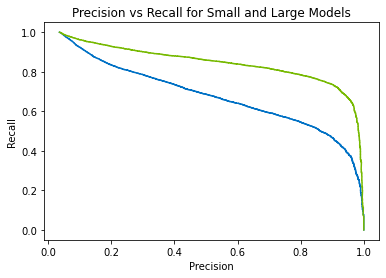

In [46]:
plt.plot(small_precision, small_recall, color='#0071c5')
plt.plot(large_precision, large_recall, color='#76b900')
plt.title('Precision vs Recall for Small and Large Models')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()

As we can see, the larger, more sophisticated model dominates the smaller model all along this curve. By deploying our model on GPU, we can identify a far greater proportion of actual fraud incidents with fewer false positives, all without going over our latency budget.

In [47]:
# Shut down the server
!docker rm -f tritonserver

tritonserver


## Conclusion
In this example notebook, we showed how to deploy an XGBoost model in Triton using the new FIL backend. While it is possible to deploy these models on both CPU and GPU in Triton, GPU-deployed models offer far higher throughput at lower latency. As a result, we can deploy more sophisticated models on the GPU for any given latency budget and thereby obtain far more accurate results.

While we have focused on XGBoost in this example, FIL also natively supports LightGBM's text serialization format as well as Treelite's checkpoint format. Thus, the same general steps can be used to serve LightGBM models and any Treelite-convertible model (including Scikit-Learn and cuML forest models). With the new FIL backend, Triton is now ready to serve forest models of all kinds in production, whether on their own or in concert with any of the deep-learning models supported by Triton.